In [ ]:
# default_exp diffusion_walks

In [1]:
#export
import numpy as np
from tqdm.auto import tqdm, trange

In [2]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

from rl_optimal_search.environment import isBetween_ab_Vec, target_search

In [3]:
%load_ext autoreload
%autoreload 2

# Lévy Walks

In [4]:
#export
def lw_step(alpha, num_part = 1):
    return (1 - np.random.rand(num_part))**(-1/alpha)

In [10]:
#export
def lw_trajs(N = 1, T = 100, alpha = 1, L = None, BC = 'reflectant'):
    
    pos = np.zeros((N, T, 2))
    
    if L is None:
        
        angles = np.random.uniform(low = 0, high = 2*np.pi, size = (N, T))
        steps = (1 - np.random.rand(N, T))**(-1/alpha)
        pos[:, :, 0], pos[:, :, 1] = [steps*np.cos(angles), steps*np.sin(angles)] 
   
        return np.cumsum(pos, axis = 1)

    else:
        
        pos = np.zeros((N, T, 2))
        pos[:, 0, :] = np.random.rand(N, 2)*L

        for t in tqdm(range(1, T)):

            angles = np.random.uniform(low = 0, high = 2*np.pi, size = N)
            steps = (1 - np.random.rand(N))**(-1/alpha)
            pos[:, t, 0] = pos[:, t-1, 0] + steps*np.cos(angles)
            pos[:, t, 1] = pos[:, t-1, 1] + steps*np.sin(angles)


        if BC == 'reflectant':
            while np.max(pos[:, t, :])>L or np.min(pos[: ,t, :])< 0: 
                pos[pos > L] = pos[pos > L] - 2*(pos[pos > L] - L)
                pos[pos < 0] = - pos[pos < 0]


        elif BC == 'periodic':
            while np.max(pos[:, t, :])>L or np.min(pos[: ,t, :])< 0: 
                pos[pos > L] = pos[pos > L] - L
                pos[pos < 0] = L + pos[pos < 0]     
        
            
        
        return pos

In [59]:
alpha = 0.5; L = 10000
N = int(1e6); T = int(1e3)

trajs = lw_trajs(N = N, T = T, alpha = alpha, L = L, BC = None)

if L is not None:
#     trajsm  = (trajs.reshape(T, N, 2) - trajs[:, 0, :]).reshape(N, T, 2)
    trajsm  = (trajs[:,:,0].transpose() - trajs[:,0,0]).transpose()


msd = np.mean(trajsm**2, axis= 0)
# msd = np.mean(msd, axis = 1)

  0%|          | 0/999 [00:00<?, ?it/s]

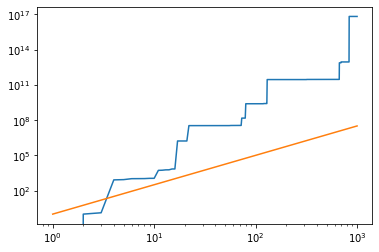

In [60]:
t = np.arange(1, msd.shape[0]+1)
plt.loglog(t, msd/msd[1], label = 'Numerics')
plt.loglog(t, t**(3-alpha))

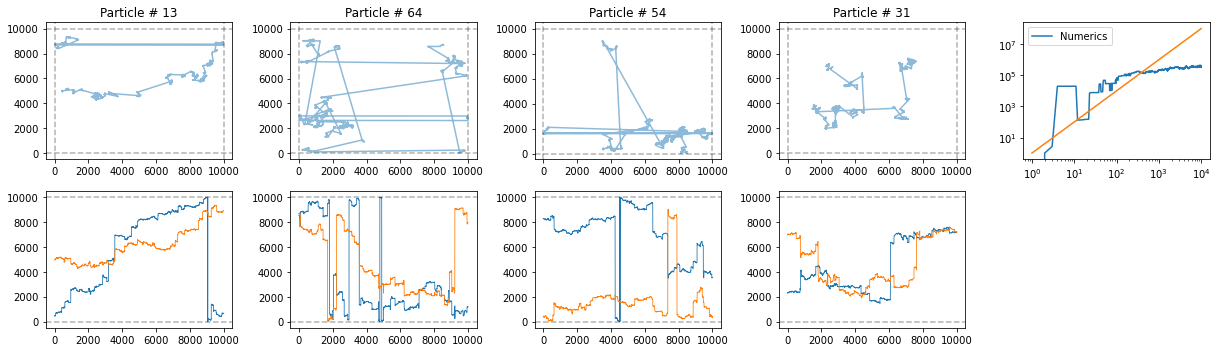

In [289]:
fig, axs = plt.subplots(2, 5, figsize = (17, 5), tight_layout = True)

for ax in axs[:, :-1].transpose():
    part = np.random.randint(N)    
    ax[0].set_title(f'Particle # {part}')
    ax[0].plot(trajs[part, :, 0], trajs[part, :, 1], alpha = 0.5)
    

    ax[1].plot(trajs[part, :, 0], '-', label = 'X', ms = 3, lw = 0.8)
    ax[1].plot(trajs[part, :, 1], '-', label = 'Y', ms = 3, lw = 0.8)

    
    if L is not None:
        ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')
        
        ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')

    
t = np.arange(1, msd.shape[0]+1)
axs[0, -1].loglog(t, msd/msd[1], label = 'Numerics')
axs[0, -1].loglog(t, t**(3-alpha))
axs[0, -1].legend()

axs[1, -1].set_axis_off()


## Searching

In [7]:
Nt = 400
density = 0.05
N = 2000; T = int(1000)
L = Nt/density
at = 0.5
ls = 3

In [8]:
target_search(Nt = Nt, N = N, T = T, alpha = 0.1, L = L, at = at, ls = ls, sample_step = lw_step, num_part = N)

  0%|          | 0/999 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
alphas = np.linspace(0.1, 1.5, 17)


results = np.array(Parallel(n_jobs=len(alphas))(delayed(target_search)(Nt = Nt, N = N, T = T, sample_step = lw_step, alpha = alpha, L = L, at = at, ls = ls)
                for alpha in alphas), dtype = object)

In [10]:
    
encs = results[:, 0]    

m_eta = np.zeros(len(alphas))
std_eta = np.zeros_like(m_eta)

for idx_a, e in enumerate(encs):
    m_eta[idx_a] = e.mean()
    std_eta[idx_a] = e.std()

# enc, real_steps = LW_search(Nt = Nt, N = N, T = T, alpha = alpha, L = L, at = at, ls =)

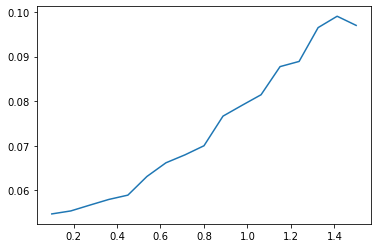

In [11]:
plt.plot(alphas, m_eta)

In [14]:
steps = results[:, 1]    

In [21]:
real_steps = []
for s in steps:
    real_steps += s

In [25]:
h, e = np.histogram(real_steps, bins = 50);

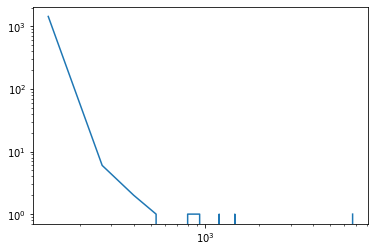

In [26]:
plt.loglog(e[1:], h)

In [56]:
pos = np.random.rand(3,5,6)
pos[(pos < 0.2) | (pos > 0.8)] = -123

## Results

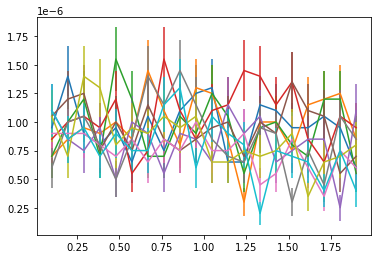

In [31]:
for m, s in zip(m_eta, std_eta):
    plt.errorbar(alphas, m, yerr=s/np.sqrt(N*T))
#     plt.show()

<ErrorbarContainer object of 3 artists>

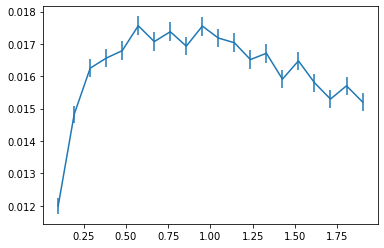

In [24]:
plt.errorbar(alphas, m_eta, yerr=std_eta/np.sqrt(e.shape[0]*e.shape[1]))

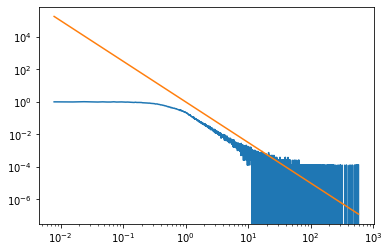

In [25]:
h, e = np.histogram(real_steps, bins = int(len(real_steps)*0.1))
plt.loglog(e[1:], h/h[0])
plt.plot(e[1:], e[1:]**(-alpha-1))

In [28]:
np.ceil(real_steps[:100])

array([1., 1., 1., 1., 1., 1., 4., 2., 3., 1., 5., 7., 1., 1., 1., 1., 2.,
       2., 2., 8., 2., 2., 2., 1., 1., 1., 1., 1., 4., 8., 1., 3., 1., 4.,
       1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 3., 1., 1., 1., 1., 2.,
       1., 1., 1., 4., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 1., 1., 1., 1., 2., 1., 2., 1., 2., 1., 1., 1., 1., 1.,
       1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 1.])

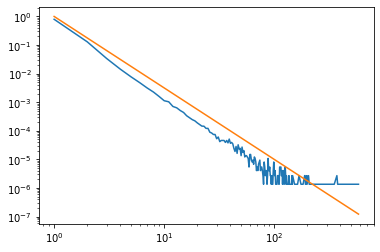

In [34]:
int_steps = np.ceil(real_steps)
h, e = np.unique(int_steps, return_counts=True)
plt.loglog(h, e/np.sum(e))
plt.plot(h, h**(-alpha-1))

In [9]:

70%30

10

In [34]:
len(enc[1])

9498

In [39]:
alpha = 1

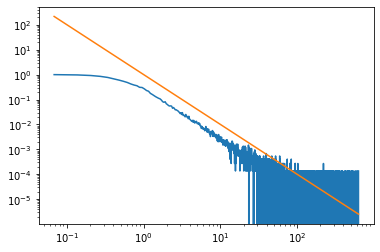

In [44]:
h, e = np.histogram(enc[1], bins = int(len(enc[1])*0.1))
plt.loglog(e[1:], h/h[0])
plt.plot(e[1:], e[1:]**(-alpha-1))

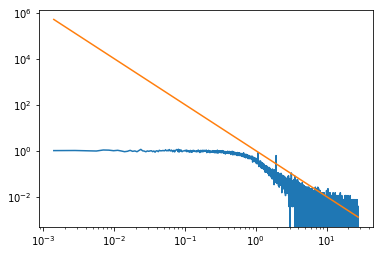

In [12]:
h, e = np.histogram(enc[1], bins = int(len(enc[1])*0.1))
plt.loglog(e[1:], h/h[0])
plt.plot(e[1:], e[1:]**(-alpha-1))

In [18]:
e

array([2.37023094e-06, 1.40173495e-03, 2.80109966e-03, ...,
       2.79802998e+01, 2.79816992e+01, 2.79830986e+01])

In [17]:
h, e = np.histogram(enc[1], bins = int(len(enc[1])*0.1))
e = e[:-1]
h[e == 1] =

143334

In [27]:
Nt = 1000
N = 10000; T = int(1e4)
L = 450 
at = 0.5

alphas = np.linspace(0.2, 2, num = 18)
pos_alpha = np.zeros((len(alphas), N, T, 2))
encounter_alpha = np.zeros((len(alphas), N, T, 2))


info = Parallel(n_jobs=18)(delayed (LW_search) (Nt = Nt, N = N, T = T, alpha = alpha, L = L, at = at)
                                    for alpha in alphas)
    

MemoryError: Unable to allocate 763. MiB for an array with shape (10000, 10000) and data type float64

In [29]:
enc = np.zeros(len(alphas))
mean = np.zeros(len(alphas))
std = np.zeros(len(alphas))



for idx, ia in enumerate(info):
    enc[idx] = np.sum(ia[1])
    totalN = np.sum(ia[1], axis = 1)
    mean[idx] = np.mean(totalN)
    std[idx] = np.std(totalN)

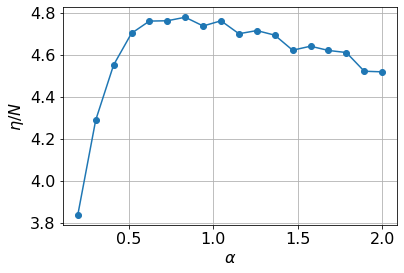

In [57]:
plt.plot(alphas, mean, 'o-')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\eta / N$')
plt.grid('on')

# Multi-exponential 

In [36]:
#export
def multiexp_dist(x, ws, ds):
    val = 0
    for wi, di in zip(ws, ds):
        # discrete normalization from 1 to inf
        norm = (wi/di)/(np.exp(1/di)-1)
        val += (1/norm)* (wi/di) * np.exp(- x / di) 
    return val/len(ws)

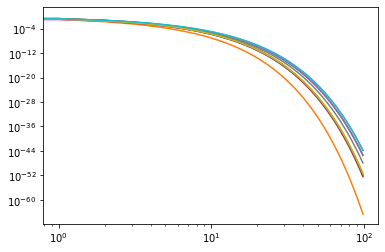

In [23]:
for idx in range(10):
    ws = np.arange(3)
    ws[0] = (10**idx)
    ws = ws/np.sum(ws)
    ds = np.random.rand(3)
    b = multiexp_dist(np.arange(1, 100), ws, ds)

    plt.loglog(b)
# plt.ylim(ymin = 1e-3)

In [41]:
#export
def discrete_multiexp_step(ws, ds, L_max=1000, num_samples = 1):
    probs = multiexp_dist(np.arange(1, L_max), ws, ds)
    probs /= np.sum(probs)
    return np.random.choice(np.arange(1, L_max), p = probs, size = num_samples)

In [24]:
samples = discrete_multiexp_step(ws, ds, num_samples=int(1e6))

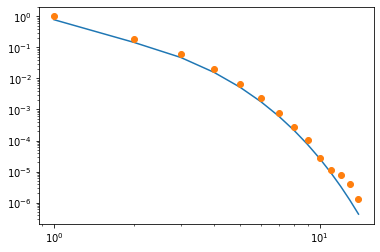

In [25]:
ls = np.arange(1, np.max(samples)+1)
true = multiexp_dist(ls, ws, ds)
u, c = np.unique(samples, return_counts = True)
# true[true < 1e-5] = 1e-5
plt.loglog(ls , true)
plt.loglog(u, c/np.max(c), 'o')


# NBDEV Export

In [43]:
from nbdev.export import notebook2script
notebook2script()

Converted cluster_launch.ipynb.
Converted diffusion_walks.ipynb.
Converted environment.ipynb.
Converted theoretical_policy.ipynb.
